In [36]:
import preprocessing.preprocessing as pp
import torch
from models import nodeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from visualization import mesh_viewer
import evaluation.evaluation as ev
import graph_matching.graph_matching as gm
import graph_matching.graph_connection as gc
import training.training as tt
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from scipy import stats
import pyvista
from tqdm import tqdm

import tifffile as tiff
import networkx as nx
from torch_geometric.utils.convert import from_networkx

# Create the graph from the combined masks and assign labels to it

In [37]:
# creating the graph
nodesFileComb =  "~/Documents/Intestine/combined-mask/nodes_bs2_fh_upsamp.csv"
edgesFileComb = "~/Documents/Intestine/combined-mask/edges_bs2_fh_upsamp.csv"

nodes_c = pd.read_csv(nodesFileComb, sep = ";", index_col= "id")
edges_c = pd.read_csv(edgesFileComb, sep = ";", index_col= "id")

# scaling with the factors provided by luciano
#nodes_c = pp.scale_position(nodes_c, (1.625,1.625,6))

# creating the graph
G_comb = pp.create_graph(nodes_c, edges_c)
G_comb_einf = pp.to_einfach(G_comb, self_loops = False, isolates = False)

### Assign the labels based on the masks

In [38]:
# base the classifcation on the mask labels at the position of the nodes
nerve_mask =  "../Intestine/nerve-mask/nerve_mask_stack_255_fh_upsamp.tif"
lymph_mask =  "../Intestine/lymph-mask/lymph_mask_stack_255_fh_upsamp.tif"

# read tif and convert to numpy 
nerve_mask_np = np.array(tiff.imread(nerve_mask)).T
lymph_mask_np = np.array(tiff.imread(lymph_mask)).T

# extracting the labels for the graph
mask_labels_num = gm.assignNodeLabelsByMaskIsotropic([nerve_mask_np, lymph_mask_np], G = G_comb_einf, voxel_size= (0.00217391,0.00217391,0.00217391), kernel_size=11) # (0.00217391,0.00217391,0.00217391) scaling_vector= (1, 1, 1),

# create dictionary to convert int labels to char labels
char_class_reverse = {}
char_class_reverse[0] = "n"
char_class_reverse[1] = "l"

# create a copy that will be used for relabeling
mask_labels = mask_labels_num.copy()

# adjust the node names
for key in mask_labels:
    mask_labels[key] = str(key) + char_class_reverse[mask_labels[key]]

# relabel the graph with the mask based labeling
G_comb_einf_lab = nx.relabel_nodes(G_comb_einf, mask_labels)
nx.write_gpickle(G_comb_einf_lab, "saved_data/graph_gt_pickle_upsamp")
nx.write_gpickle(G_comb_einf, "saved_data/graph_gt_pickle_nolab_upsamp")

# check if all the masks have a label (otherwise class -1 exists)
np.unique(list(mask_labels_num.values()), return_counts = True)


100%|██████████| 4375/4375 [00:00<00:00, 25384.61it/s]


(array([0, 1]), array([1592, 2783]))

### Visualize the graph

Primal graph from combined extraction with mask based labeling.


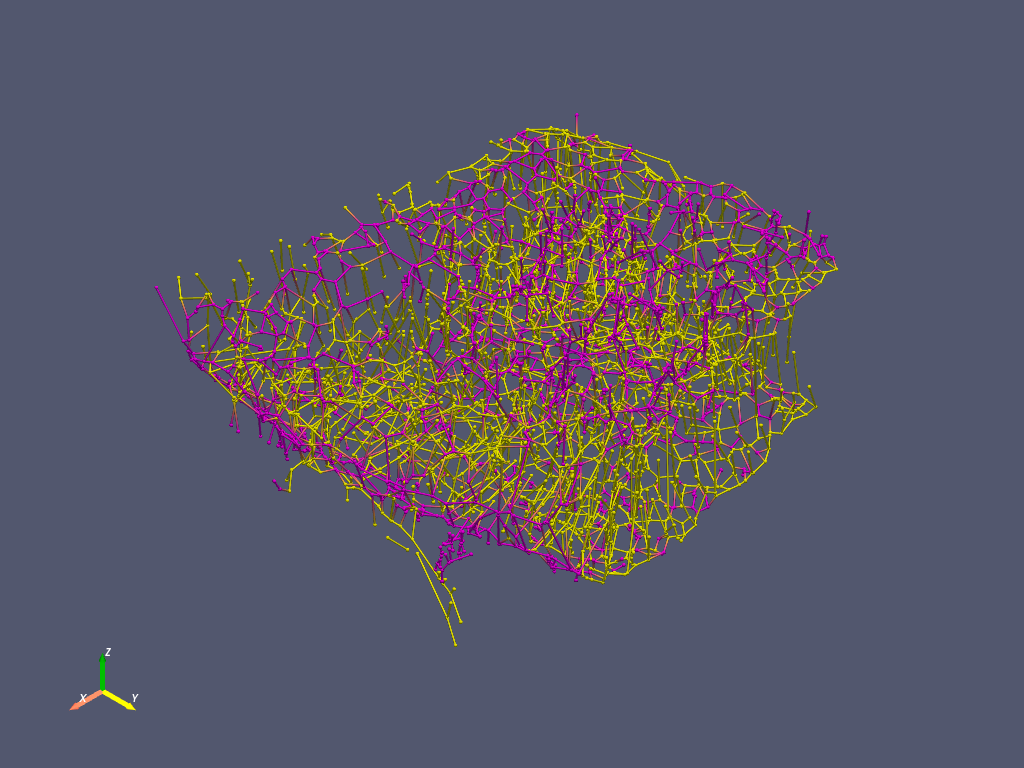

In [4]:
print("Primal graph from combined extraction with mask based labeling.")
mesh_viewer.renderNXGraph(G_comb_einf_lab, dual = False, vtk = 0,backend = "static")

### Create and visualize the dual graph

Dual graph from combined extraction with mask based labeling.


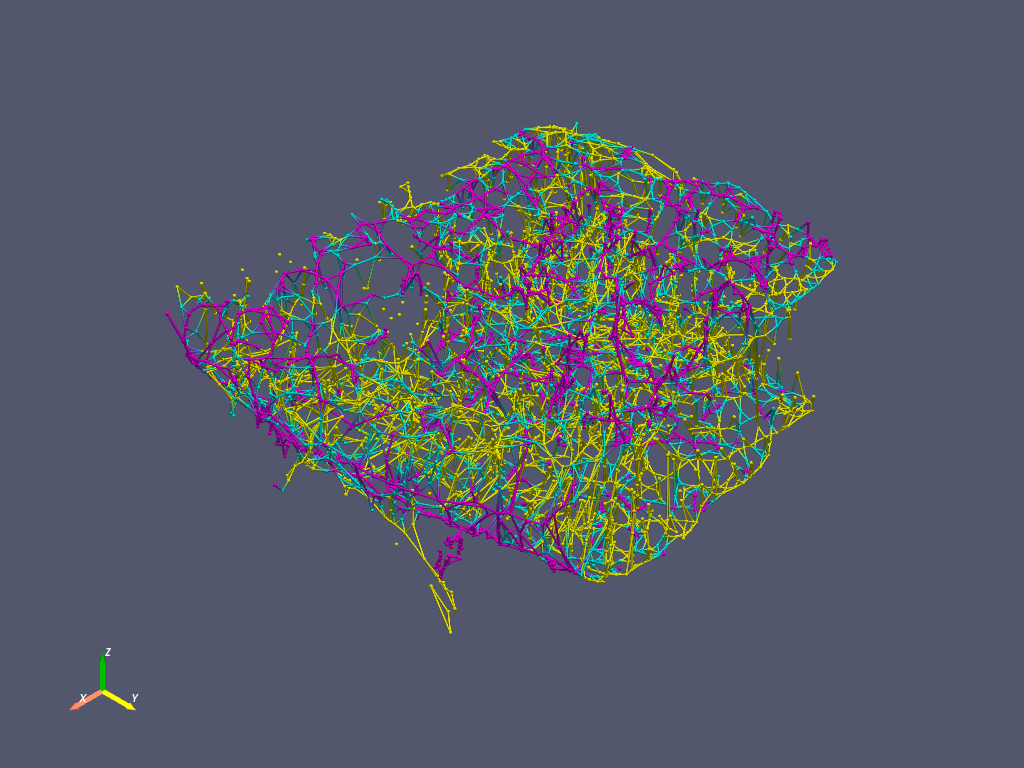

In [20]:
# labeling based on the primal labeling
L_comb_einf_lab_old = pp.make_dual(G_comb_einf_lab, include_orientation= False)
print("Dual graph from combined extraction with mask based labeling.")
mesh_viewer.renderNXGraph(L_comb_einf_lab_old, dual = True, vtk = 0, backend = "static")


# Start playing with models for node classification

In [8]:
# loading potential architectures
netGCN = nodeClassifier.GCN_VS
netSAGE = nodeClassifier.SAGE_VS
netGAT = nodeClassifier.GAT_VS

### Classification on G

In [9]:
# enrich nodes with information form edges
pp.enrich_node_attrs(G_comb_einf_lab)
GX_comb_einf_lab = from_networkx(G_comb_einf_lab)
GX_comb_einf_lab.y = torch.tensor(list(mask_labels_num.values()))


# extract the classes and features for model input
num_feat_comb = GX_comb_einf_lab.x.shape[1]
num_class_comb = len(np.unique(GX_comb_einf_lab.y))


# create a network arch
SAGE1 = nodeClassifier.nodeClassifier(netSAGE, 64, features = np.arange(num_feat_comb), classes = num_class_comb, num_layers= 4,  lr = 0.00134, weight_decay= 0.0002) 

# create a trainer for the model
# this way a random split is done
SAGE1_TR = tt.Trainer(SAGE1,GX_comb_einf_lab)


# create a trainer with slicing by z axis 
# slicing along any other axis than y does not really make sense - y slicing goes along the path of the intestine

SAGE1_TR_y = tt.Trainer(SAGE1,GX_comb_einf_lab, split= (0,1,0))


100%|██████████| 10/10 [00:00<00:00, 10.55it/s]


Total number of epochs: 10


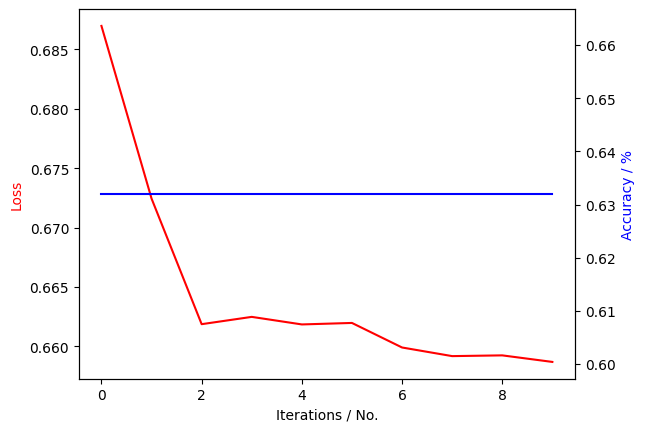

In [10]:
# train the model for a given number of epochs
loss_l, acc_l = SAGE1_TR.trainXepochs(10)

# total number of training epoch for this model
print("Total number of epochs: " + str(SAGE1_TR.totalEpoch))

# plot the loss and val acc over the epochs
ev.plot_loss_acc(loss_l, acc_l)

Validation set accuracy:  0.6320
Train set accuracy: 0.6371
Validation set balanced accuracy:  0.5000
Train set balanced accuracy: 0.5000


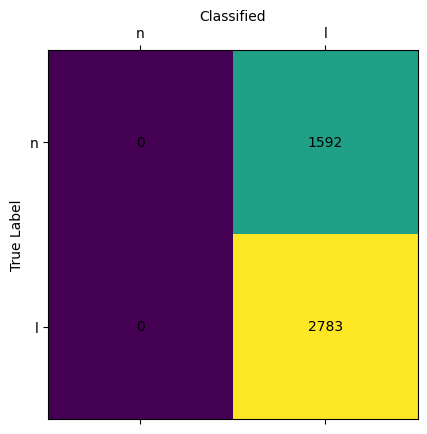

In [34]:
full_mask_comb = torch.tensor(np.arange(0, GX_comb_einf_lab.y.shape[0]))
pred_whole_comb = SAGE1_TR.model.predictions(GX_comb_einf_lab)
pred_whole_comb_acc = SAGE1_TR.model.test(GX_comb_einf_lab, full_mask_comb)


print(f"Validation set accuracy:  {accuracy_score(SAGE1_TR.nxGraph.y[SAGE1_TR.test_mask], pred_whole_comb[SAGE1_TR.test_mask]):.4f}")
print(f"Train set accuracy: {accuracy_score(SAGE1_TR.nxGraph.y[SAGE1_TR.train_mask], pred_whole_comb[SAGE1_TR.train_mask]):.4f}")

print(f"Validation set balanced accuracy:  {balanced_accuracy_score(SAGE1_TR.nxGraph.y[SAGE1_TR.test_mask], pred_whole_comb[SAGE1_TR.test_mask]):.4f}")
print(f"Train set balanced accuracy: {balanced_accuracy_score(SAGE1_TR.nxGraph.y[SAGE1_TR.train_mask], pred_whole_comb[SAGE1_TR.train_mask]):.4f}")
ev.plot_confusion_matrix(np.array(SAGE1_TR.nxGraph.y), pred_whole_comb, char_class_reverse.values())


# somehow this bugs
#rocL_comb = ev.eval_roc_auc(GX_comb_einf_lab.y, SAGE1_TR.model.predictions(GX_comb_einf_lab, max_prob = False))
#print("ROC AUC: " + str(rocL_comb))


### Classification on L

### Split the graph and train/test on different parts of the graph

In [39]:
path = "/home/laurin/Documents/Intestine/combined-mask/vg_bs2_fh_upsamp.vvg"
L_comb_einf_lab = pp.make_dual(G_comb_einf, include_orientation= False)
df_centerline = pp.vvg_to_df(path)
label_dict, label_dict_nodes = pp.label_edges_centerline([nerve_mask_np, lymph_mask_np], voxel_size = (0.00217391,0.00217391,0.00217391), df_centerline=df_centerline)


clenead_label_dict = {}
for key, val in label_dict_nodes.items():
    if key[0] == key[1]:
        continue
    try:
        L_comb_einf_lab[key]
        clenead_label_dict[key] = val
    except KeyError:
        L_comb_einf_lab[(key[1],key[0])]
        clenead_label_dict[(key[1],key[0])] = val


nx.set_node_attributes(L_comb_einf_lab,clenead_label_dict, "y")
nx.write_gpickle(L_comb_einf_lab, "saved_data/graph_gt_L_pickle_upsamp")


LX_comb_einf_lab = from_networkx(L_comb_einf_lab)
#class_label_list, node_lab, node_lab_explain =  pp.label_dual(L_comb_einf_lab, overrule = "l")

#y_dict_L_comb_einf_lab = dict(zip(list(L_comb_einf_lab.nodes()), class_label_list))
#nx.set_node_attributes(L_comb_einf_lab, y_dict_L_comb_einf_lab, "y")

# assign the ground truth class information to the torch data obj
#LX_comb_einf_lab.y = torch.tensor(class_label_list)


# labeling based on the centerline


In [25]:
splitter = tt.Splitter(LX_comb_einf_lab)

train_mask, test_mask, splitValue = splitter.split_geometric((0,1,0), frac = 0.5)

train_list = np.array(list(L_comb_einf_lab.nodes()))[train_mask].tolist()
train_nodes = [(elem[0],elem[1]) for elem in train_list]

test_list = np.array(list(L_comb_einf_lab.nodes()))[test_mask].tolist()
test_nodes = [(elem[0],elem[1]) for elem in test_list]

train_subG = L_comb_einf_lab.subgraph(train_nodes)
test_subG = L_comb_einf_lab.subgraph(test_nodes)

#nx.write_gpickle(train_subG, "saved_data/graph_L05_train_gt_pickle_upsamp")
#nx.write_gpickle(test_subG, "saved_data/graph_L05_test_gt_pickle_upsamp")


In [16]:
#print("Dual graph only test part.")
#mesh_viewer.renderNXGraph(test_subG, dual = True, vtk = 0,backend = "static")
#print("Dual graph only train part.")
#mesh_viewer.renderNXGraph(train_subG, dual = True, vtk = 0,backend = "static")

In [30]:
split_wholeG = nx.union(train_subG, test_subG)

split_wholeG_torch = from_networkx(split_wholeG)
#split_wholeG_y, _, _ =  pp.label_dual(split_wholeG, node_lab, overrule = "l")

#split_wholeG_torch.y = torch.tensor(split_wholeG_y)

num_feat_dual = split_wholeG_torch.x.shape[1]
num_class_dual = np.unique(split_wholeG_torch.y).shape[0]

geom_train_mask_torch = np.arange(0, train_subG.order())
geom_test_mask_torch = np.arange(train_subG.order(),train_subG.order()+ test_subG.order())

# create the training and testing masks
train_mask_random = np.random.choice(np.arange(0, geom_train_mask_torch.shape[0]), size= int(geom_train_mask_torch.shape[0]*0.85), replace = False)
test_mask_random = np.delete(np.arange(0, geom_train_mask_torch.shape[0]), train_mask_random)


SAGE_geom = nodeClassifier.nodeClassifier(netSAGE, 64, features = np.arange(num_feat_dual), classes = num_class_dual,  num_layers= 4,  lr = 0.00607, weight_decay= 0.000101) 

#SAGE_geom.model = netSAGE(num_feat_dual, 64, num_class_dual, dropout = 0.5, num_layers = 4, MLP = True, skip = True, norm = False, aggr = "std")
#SAGE_geom.optimizer = torch.optim.AdamW(SAGE_geom.model.parameters(), lr= 0.00607, weight_decay= 0.0001871)


SAGE_geom.model = netGCN(in_channels = num_feat_dual, hidden_channels= 64, num_layers = 2, out_channels = num_class_dual, dropout = 0.5, MLP = True, skip = True)
SAGE_geom.optimizer = torch.optim.AdamW(SAGE_geom.model.parameters(), lr= 0.00239, weight_decay= 0.0002296)


epochs = 1000
res_arr = np.zeros((epochs,3))
for epoch in tqdm(range(0, epochs)):
    loss = SAGE_geom.train(split_wholeG_torch, train_mask_random)
    res_arr[epoch,0] = loss
    val_acc = SAGE_geom.test(split_wholeG_torch, test_mask_random)
    res_arr[epoch,1] = val_acc
    test_acc = SAGE_geom.test(split_wholeG_torch, geom_test_mask_torch)
    res_arr[epoch,2] = test_acc

    #print(f"Epoch: {1+epoch:03d}, Loss: {loss:.3f}, Val. Acc: {val_acc:.3f}, Test Acc: {test_acc:.3f}")

100%|██████████| 1000/1000 [01:54<00:00,  8.76it/s]


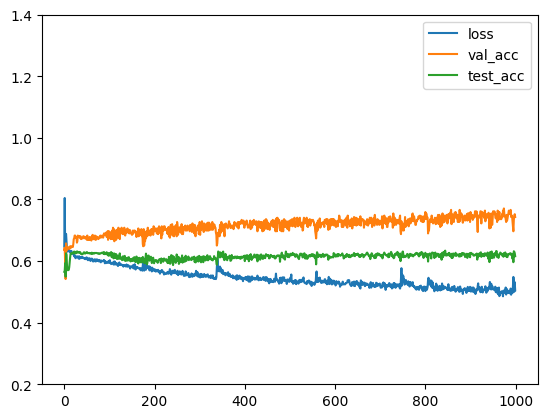

In [31]:
plt.plot(res_arr)
plt.ylim(0.2,1.4)
plt.legend(("loss","val_acc", "test_acc"))
plt.show()

Training accuracy:  0.7527
Training balanced accuracy:  0.7334


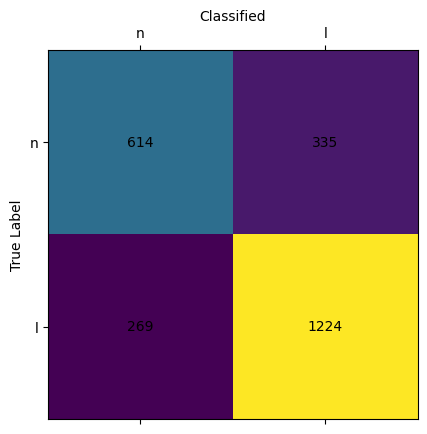

Validation (transductive) accuracy:  0.7431
Validation (transductive) balanced accuracy:  0.7230


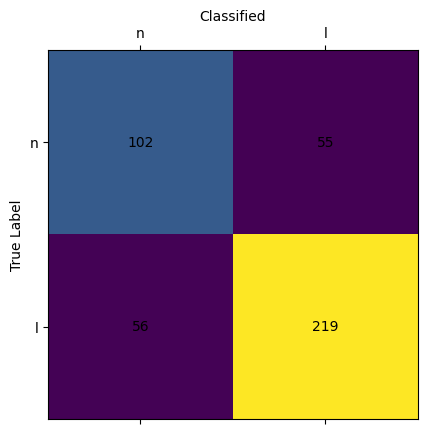

Test (inductive) accuracy:  0.6159
Test (inductive) balanced accuracy:  0.6045


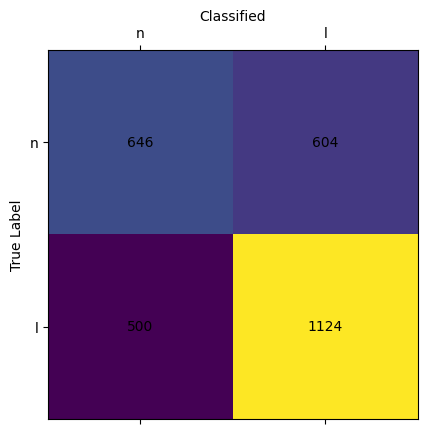

In [33]:
pred_split = SAGE_geom.predictions(split_wholeG_torch)

#conf_labels =node_lab_explain.values()
conf_labels = ["n","l"]

# train loss
print(f"Training accuracy:  {accuracy_score(split_wholeG_torch.y[train_mask_random], pred_split[train_mask_random]):.4f}")
print(f"Training balanced accuracy:  {balanced_accuracy_score(split_wholeG_torch.y[train_mask_random], pred_split[train_mask_random]):.4f}")
ev.plot_confusion_matrix(np.array(split_wholeG_torch.y[train_mask_random]), pred_split[train_mask_random], conf_labels)

# validation loss - transductive
print(f"Validation (transductive) accuracy:  {accuracy_score(split_wholeG_torch.y[test_mask_random], pred_split[test_mask_random]):.4f}")
print(f"Validation (transductive) balanced accuracy:  {balanced_accuracy_score(split_wholeG_torch.y[test_mask_random], pred_split[test_mask_random]):.4f}")
ev.plot_confusion_matrix(np.array(split_wholeG_torch.y[test_mask_random]), pred_split[test_mask_random], conf_labels)

# validation loss - inductive
print(f"Test (inductive) accuracy:  {accuracy_score(split_wholeG_torch.y[geom_test_mask_torch], pred_split[geom_test_mask_torch]):.4f}")
print(f"Test (inductive) balanced accuracy:  {balanced_accuracy_score(split_wholeG_torch.y[geom_test_mask_torch], pred_split[geom_test_mask_torch]):.4f}")
ev.plot_confusion_matrix(np.array(split_wholeG_torch.y[geom_test_mask_torch]), pred_split[geom_test_mask_torch], conf_labels)

### Try to visualize the created node embedding for the training, validation and test nodes

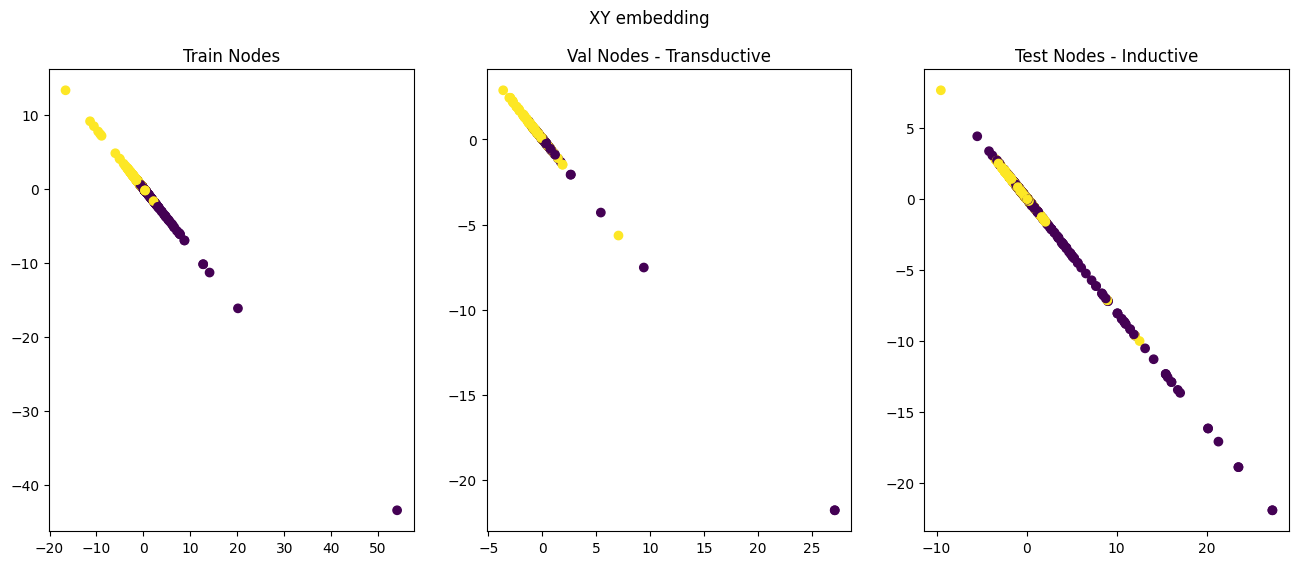

In [34]:
pred_split_prob = SAGE_geom.predictions(split_wholeG_torch, max_prob = False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6),)
fig.suptitle('XY embedding')

ax1.set_title("Train Nodes")
ax1.scatter(pred_split_prob[train_mask_random,0],pred_split_prob[train_mask_random,1], c = split_wholeG_torch.y[train_mask_random])
ax2.set_title("Val Nodes - Transductive")
ax2.scatter(pred_split_prob[test_mask_random,0],pred_split_prob[test_mask_random,1], c = split_wholeG_torch.y[test_mask_random])
ax3.set_title("Test Nodes - Inductive")
ax3.scatter(pred_split_prob[geom_test_mask_torch,0],pred_split_prob[geom_test_mask_torch,1], c = split_wholeG_torch.y[geom_test_mask_torch])
plt.show()

IndexError: index 2 is out of bounds for dimension 1 with size 2

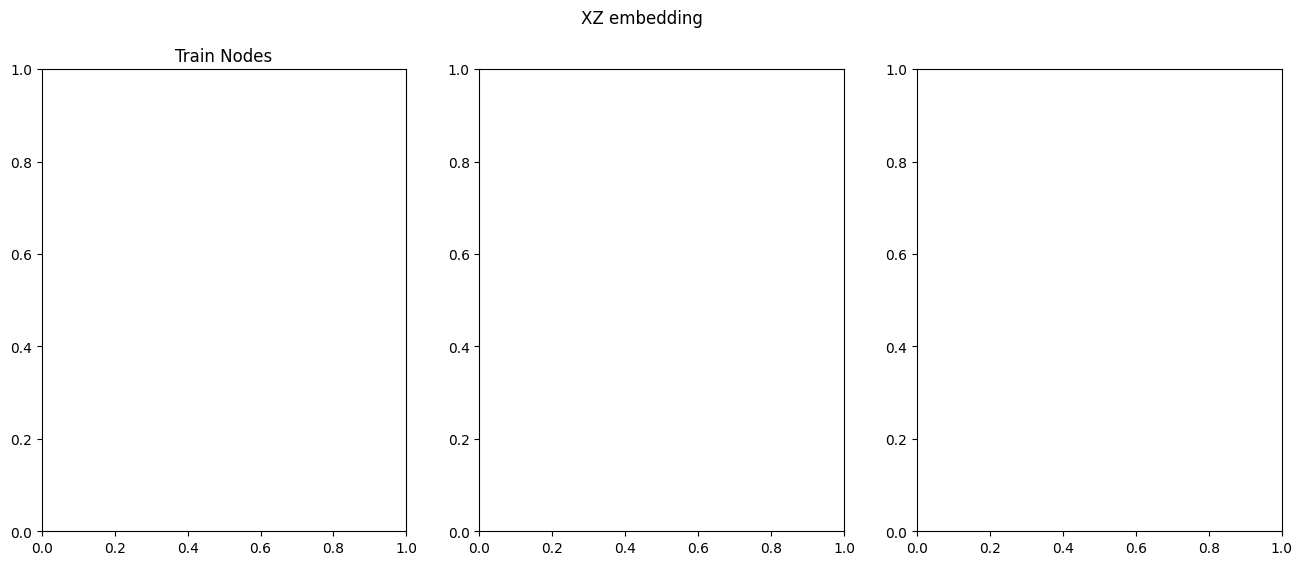

In [15]:
pred_split_prob = SAGE_geom.predictions(split_wholeG_torch, max_prob = False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6),)
fig.suptitle('XZ embedding')

ax1.set_title("Train Nodes")
ax1.scatter(pred_split_prob[train_mask_random,0],pred_split_prob[train_mask_random,2], c = split_wholeG_torch.y[train_mask_random])
ax2.set_title("Val Nodes - Transductive")
ax2.scatter(pred_split_prob[test_mask_random,0],pred_split_prob[test_mask_random,2], c = split_wholeG_torch.y[test_mask_random])
ax3.set_title("Test Nodes - Inductive")
ax3.scatter(pred_split_prob[geom_test_mask_torch,0],pred_split_prob[geom_test_mask_torch,2], c = split_wholeG_torch.y[geom_test_mask_torch])
plt.show()

IndexError: index 2 is out of bounds for dimension 1 with size 2

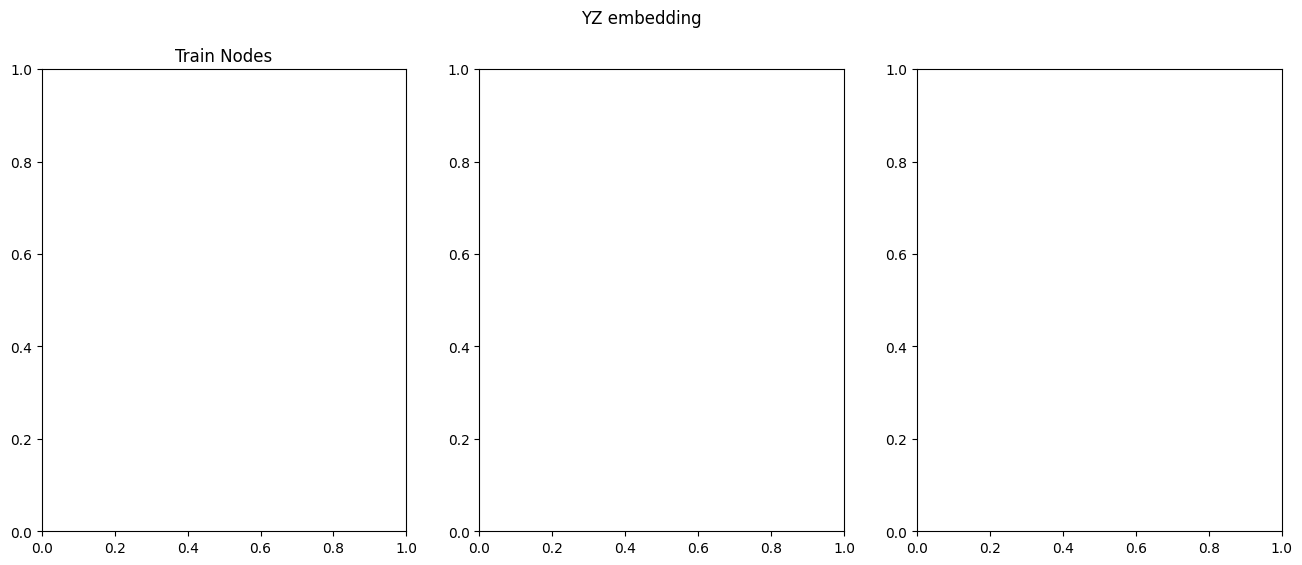

In [20]:
pred_split_prob = SAGE_geom.predictions(split_wholeG_torch, max_prob = False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6),)
fig.suptitle('YZ embedding')

ax1.set_title("Train Nodes")
ax1.scatter(pred_split_prob[train_mask_random,1],pred_split_prob[train_mask_random,2], c = split_wholeG_torch.y[train_mask_random])
ax2.set_title("Val Nodes - Transductive")
ax2.scatter(pred_split_prob[test_mask_random,1],pred_split_prob[test_mask_random,2], c = split_wholeG_torch.y[test_mask_random])
ax3.set_title("Test Nodes - Inductive")
ax3.scatter(pred_split_prob[geom_test_mask_torch,1],pred_split_prob[geom_test_mask_torch,2], c = split_wholeG_torch.y[geom_test_mask_torch])
plt.show()

In [115]:
from sklearn import manifold
from numpy.random import RandomState
rng = RandomState(0)

t_sne = manifold.TSNE(
    n_components=2,
    learning_rate="auto",
    perplexity=30,
    n_iter=250,
    init="random",
    random_state=rng,
)

S_t_sne_train = t_sne.fit_transform(pred_split_prob[train_mask_random])
S_t_sne_val = t_sne.fit_transform(pred_split_prob[test_mask_random])
S_t_sne_test = t_sne.fit_transform(pred_split_prob[geom_test_mask_torch])

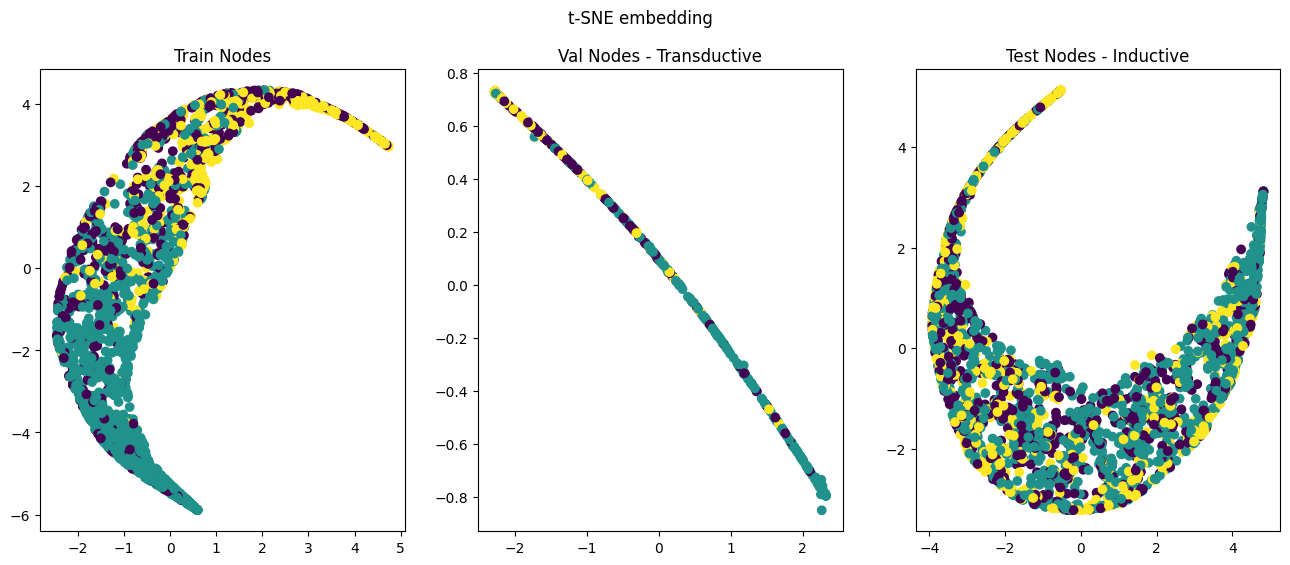

In [118]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6),)
fig.suptitle('t-SNE embedding')

ax1.set_title("Train Nodes")
ax1.scatter(S_t_sne_train[:,0], S_t_sne_train[:,1],c = split_wholeG_torch.y[train_mask_random])
ax2.set_title("Val Nodes - Transductive")
ax2.scatter(S_t_sne_val[:,0], S_t_sne_val[:,1],c = split_wholeG_torch.y[test_mask_random])
ax3.set_title("Test Nodes - Inductive")
ax3.scatter(S_t_sne_test[:,0], S_t_sne_test[:,1],c = split_wholeG_torch.y[geom_test_mask_torch])
plt.show()

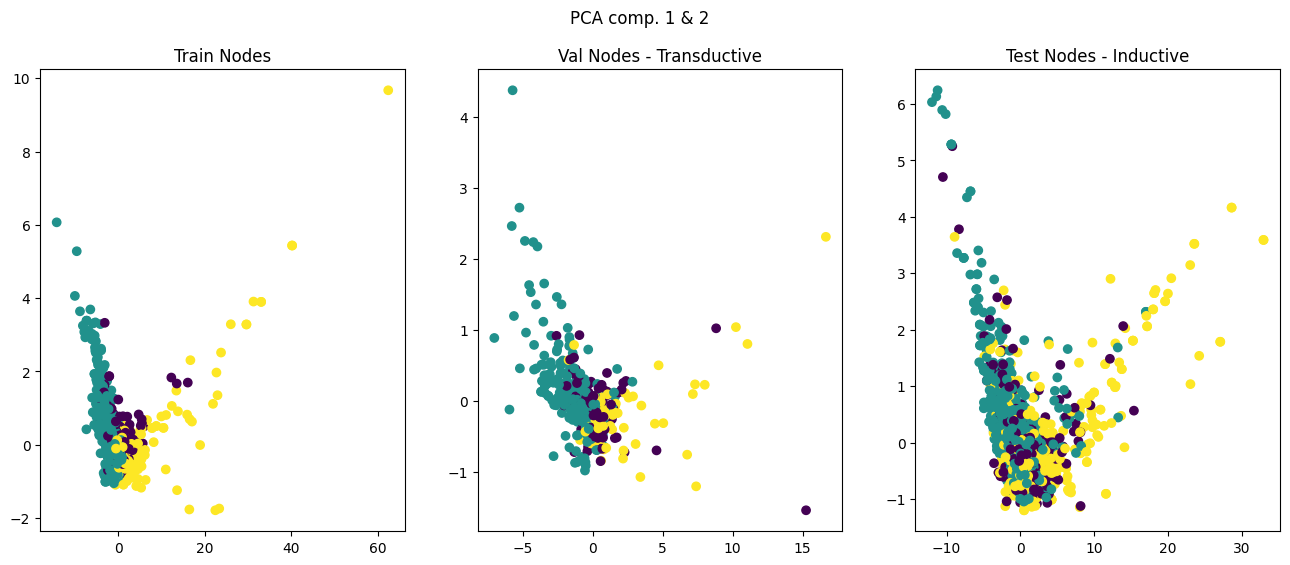

In [131]:

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_transform = pca.fit_transform(pred_split_prob)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6),)
fig.suptitle('PCA comp. 1 & 2')

ax1.set_title("Train Nodes")
ax1.scatter(pca_transform[train_mask_random,0],pca_transform[train_mask_random,1], c = split_wholeG_torch.y[train_mask_random])
ax2.set_title("Val Nodes - Transductive")
ax2.scatter(pca_transform[test_mask_random,0],pca_transform[test_mask_random,1], c = split_wholeG_torch.y[test_mask_random])
ax3.set_title("Test Nodes - Inductive")
ax3.scatter(pca_transform[geom_test_mask_torch,0],pca_transform[geom_test_mask_torch,1], c = split_wholeG_torch.y[geom_test_mask_torch])
plt.show()

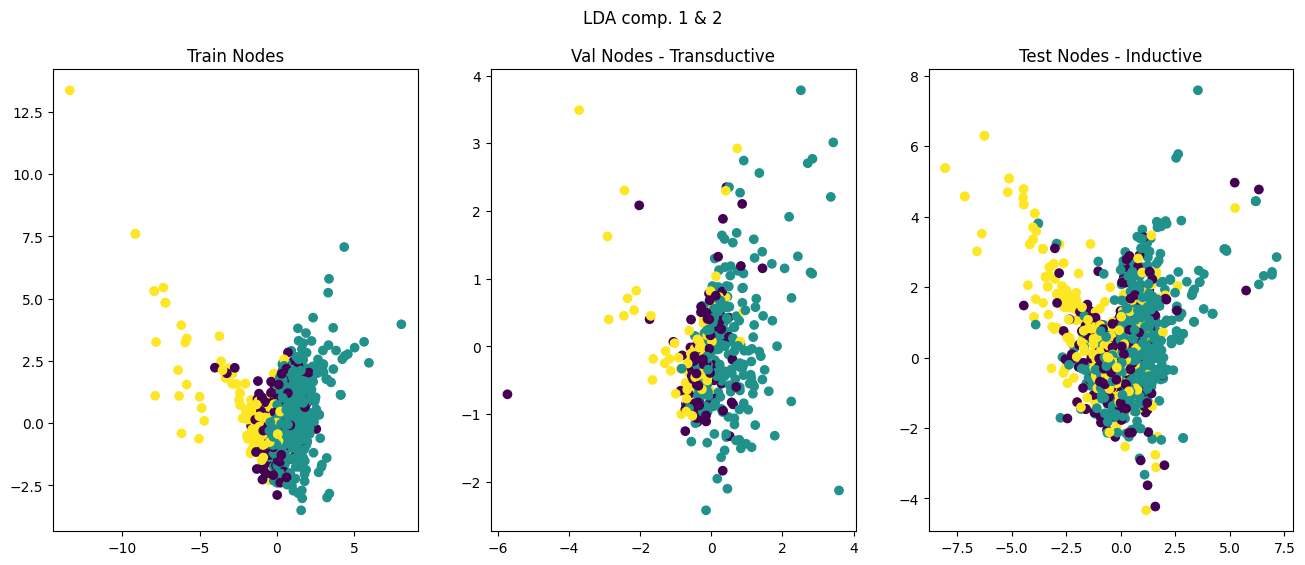

In [132]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
lda_transform = lda.fit(pred_split_prob, split_wholeG_torch.y).transform(pred_split_prob)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6),)
fig.suptitle('LDA comp. 1 & 2')

ax1.set_title("Train Nodes")
ax1.scatter(lda_transform[train_mask_random,0],lda_transform[train_mask_random,1], c = split_wholeG_torch.y[train_mask_random])
ax2.set_title("Val Nodes - Transductive")
ax2.scatter(lda_transform[test_mask_random,0],lda_transform[test_mask_random,1], c = split_wholeG_torch.y[test_mask_random])
ax3.set_title("Test Nodes - Inductive")
ax3.scatter(lda_transform[geom_test_mask_torch,0],lda_transform[geom_test_mask_torch,1], c = split_wholeG_torch.y[geom_test_mask_torch])
plt.show()

In [151]:
#for viridis: 0 is purple, 1 is blue, 2 is yellow ()

#simple classification by threshold
_, train_counts = np.unique(split_wholeG_torch.y[train_mask_random], return_counts = True)

sl_train = split_wholeG_torch.y[train_mask_random][lda_transform[train_mask_random,0] > 0]
_, sl_train_counts = np.unique(sl_train, return_counts = True)

sh_train = split_wholeG_torch.y[train_mask_random][lda_transform[train_mask_random,0] <= 0]
_, sh_train_counts = np.unique(sh_train, return_counts = True)

for i, ct in enumerate(train_counts):
    print(f"count: {ct}")
    print(f"Low:  {sl_train_counts[i]/ct*100:.2f}% versus High: {sh_train_counts[i]/ct*100:.2f}%" )

print("##################")

#simple classification by threshold
_, train_counts = np.unique(split_wholeG_torch.y[test_mask_random], return_counts = True)

sl_train = split_wholeG_torch.y[test_mask_random][lda_transform[test_mask_random,0] > 0]
_, sl_train_counts = np.unique(sl_train, return_counts = True)

sh_train = split_wholeG_torch.y[test_mask_random][lda_transform[test_mask_random,0] <= 0]
_, sh_train_counts = np.unique(sh_train, return_counts = True)

for i, ct in enumerate(train_counts):
    print(f"count: {ct}")
    print(f"Low:  {sl_train_counts[i]/ct*100:.2f}% versus High: {sh_train_counts[i]/ct*100:.2f}%" )

print("##################")

#simple classification by threshold
_, train_counts = np.unique(split_wholeG_torch.y[geom_test_mask_torch], return_counts = True)

sl_train = split_wholeG_torch.y[geom_test_mask_torch][lda_transform[geom_test_mask_torch,0] > 0]
_, sl_train_counts = np.unique(sl_train, return_counts = True)

sh_train = split_wholeG_torch.y[geom_test_mask_torch][lda_transform[geom_test_mask_torch,0] <= 0]
_, sh_train_counts = np.unique(sh_train, return_counts = True)

for i, ct in enumerate(train_counts):
    print(f"count: {ct}")
    print(f"Low:  {sl_train_counts[i]/ct*100:.2f}% versus High: {sh_train_counts[i]/ct*100:.2f}%" )



count: 604
Low:  32.78% versus High: 67.22%
count: 1268
Low:  72.24% versus High: 27.76%
count: 570
Low:  8.07% versus High: 91.93%
##################
count: 110
Low:  27.27% versus High: 72.73%
count: 232
Low:  69.40% versus High: 30.60%
count: 90
Low:  16.67% versus High: 83.33%
##################
count: 695
Low:  34.96% versus High: 65.04%
count: 1420
Low:  54.30% versus High: 45.70%
count: 759
Low:  23.85% versus High: 76.15%


In [121]:
from torch_geometric.nn import GNNExplainer

node_idx = 100
x, edge_index = split_wholeG_torch.x.float(), split_wholeG_torch.edge_index
explainer = GNNExplainer(SAGE_geom.model, epochs=10)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index, training = False)

print(f"Node Class: {split_wholeG_torch.y[node_idx]}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x17 and 16x64)

In [ ]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=LX_comb_einf_lab.y)
print(node_feat_mask)
plt.show()